In [2]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torchvision


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [13]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def project1_model():
    return ResNet(BasicBlock, [1, 1, 1, 1])

In [14]:
Transform =  transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
trainingdata = torchvision.datasets.CIFAR10(root='./ data', train=True, download=True, transform=Transform) 
Transform =  transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
testdata = torchvision.datasets.CIFAR10(root='./data',  train=False, download=True, transform=Transform)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
trainDataLoader = DataLoader(trainingdata, batch_size= 64, shuffle=True,num_workers=4)
testDataLoader = DataLoader(testdata, batch_size= 64, shuffle=False,num_workers=4)

In [16]:
model=project1_model()
Loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    model.cuda()

In [17]:
from torchsummary import summary
summary(model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            1,728
├─BatchNorm2d: 1-2                       128
├─Sequential: 1-3                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─Conv2d: 3-3                  36,864
|    |    └─BatchNorm2d: 3-4             128
|    |    └─Sequential: 3-5              --
├─Sequential: 1-4                        --
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  73,728
|    |    └─BatchNorm2d: 3-7             256
|    |    └─Conv2d: 3-8                  147,456
|    |    └─BatchNorm2d: 3-9             256
|    |    └─Sequential: 3-10             8,448
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 294,912
|    |    └─BatchNorm2d: 3-12            512
|    |    └─Conv2d: 3-13             

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            1,728
├─BatchNorm2d: 1-2                       128
├─Sequential: 1-3                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─Conv2d: 3-3                  36,864
|    |    └─BatchNorm2d: 3-4             128
|    |    └─Sequential: 3-5              --
├─Sequential: 1-4                        --
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  73,728
|    |    └─BatchNorm2d: 3-7             256
|    |    └─Conv2d: 3-8                  147,456
|    |    └─BatchNorm2d: 3-9             256
|    |    └─Sequential: 3-10             8,448
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 294,912
|    |    └─BatchNorm2d: 3-12            512
|    |    └─Conv2d: 3-13             

In [23]:
train_loss_history = []
test_loss_history = []
train_acc_history = [] 
test_acc_history = [] 


for epoch in range(20):
    train_loss = 0.0
    test_loss = 0.0
    correct_points_train = 0 
    correct_points_test = 0 
    for i, data in enumerate(trainDataLoader):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predicted_output = model(images)
        fit = Loss(predicted_output,labels)
        fit.backward()
        optimizer.step()
        train_loss += fit.item()
        _, preds = torch.max(predicted_output,1)
        correct_points_train += torch.sum(preds == labels.data) #.data.cpu().numpy()
    for i, data in enumerate(testDataLoader):
        with torch.no_grad():
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            predicted_output = model(images)
            fit = Loss(predicted_output,labels)
            test_loss += fit.item()
            #print(predicted_output.shape)
            _, preds = torch.max(predicted_output,1)
            correct_points_test += torch.sum(preds == labels.data) #.data.cpu().numpy()
            
           
            
    train_loss = train_loss/len(trainDataLoader)
    test_loss = test_loss/len(testDataLoader)
    
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    
    train_acc = correct_points_train/len(trainDataLoader) 
    print("len of train data:",len(trainDataLoader))
    test_acc = correct_points_test/len(testDataLoader)
    print("len  of testdataloader:",len(testDataLoader))
    
    train_acc_history.append(train_acc) 
    test_acc_history.append(test_acc)

    print('Epoch %s, Train loss %s, Test loss %s Train accuracy %s Test accuracy  %s'%(epoch, train_loss, test_loss, train_acc, test_acc))
    #print("Accuracy:", (torch.eq(torch.max(predicted_output, 1)[1],labels).sum()/len(labels)*100).data.cpu().numpy())

len of train data: 782
len  of testdataloader: 157
Epoch 0, Train loss 1.3399652465987388, Test loss 1.2874177109663654 Train accuracy tensor(32.7903, device='cuda:0') Test accuracy  tensor(33.9745, device='cuda:0')
len of train data: 782
len  of testdataloader: 157
Epoch 1, Train loss 1.2969916161063992, Test loss 1.2223115426719569 Train accuracy tensor(34.0051, device='cuda:0') Test accuracy  tensor(36., device='cuda:0')
len of train data: 782
len  of testdataloader: 157
Epoch 2, Train loss 1.252819352137768, Test loss 1.2094370593690569 Train accuracy tensor(35.1969, device='cuda:0') Test accuracy  tensor(35.9427, device='cuda:0')
len of train data: 782
len  of testdataloader: 157
Epoch 3, Train loss 1.212410537940462, Test loss 1.144773872794619 Train accuracy tensor(36.0652, device='cuda:0') Test accuracy  tensor(37.5223, device='cuda:0')
len of train data: 782
len  of testdataloader: 157
Epoch 4, Train loss 1.1717435537701677, Test loss 1.101238402971037 Train accuracy tensor(37

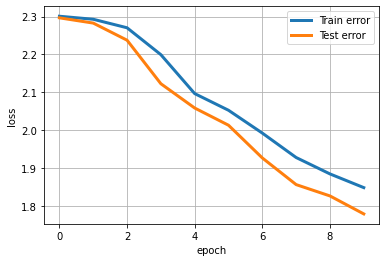

In [58]:
#import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(10),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(10),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()